In [ ]:
import sys
sys.path.append('/home/elena/astrocosmolib/')

import numpy as np
import matplotlib.pyplot as plt 


from tqdm.notebook import tqdm

In [42]:
omegam, chi2 = np.load("chi2_values.npy")
posterior = np.exp(-0.5 * chi2)

In [43]:
from scipy.interpolate import interp1d

interp_chi2 = interp1d(omegam, -0.5*chi2, kind='cubic')

In [44]:
def MCMC(x0, n_steps, x_min, x_max):
    chain = []
    accepted = []
    chi2_chain = []

    chain.append(x0)
    accepted.append(True)
    chi2_chain.append(interp_chi2(x0))

    for i in tqdm(range(n_steps)):
        x_try = np.random.uniform(x_min, x_max)
        f_try = interp_chi2(x_try)
        f_old = interp_chi2(chain[-1])
        log_ratio = f_try - f_old
        log_u = np.log(np.random.uniform())

        if log_u < log_ratio:
            chain.append(x_try)
            accepted.append(True)
            chi2_chain.append(f_try)
        else:   
            chain.append(chain[-1])
            accepted.append(False)
            chi2_chain.append(f_old)
    
    return chain, chi2_chain, accepted

  0%|          | 0/10000 [00:00<?, ?it/s]

Acceptance rate:  0.198980101989801


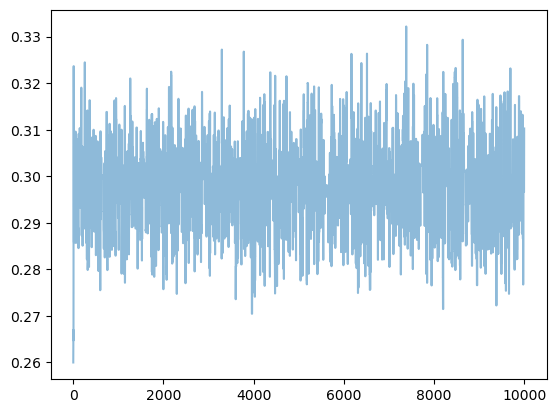

In [45]:
x_min = 0.23
x_max = 0.37
n_steps = 10000
x0 = 0.26

chain, chi2_chain, accepted = MCMC(x0, n_steps, x_min, x_max)

print("Acceptance rate: ", np.sum(accepted) / len(accepted))
plt.plot(chain, alpha=0.5)
plt.show()

In [46]:
#media e std della chain
print("Omega_m: ", np.mean(chain[:1000]), "+/-", np.std(chain[:1000]))

Omega_m:  0.29672735837652053 +/- 0.008755643417285575


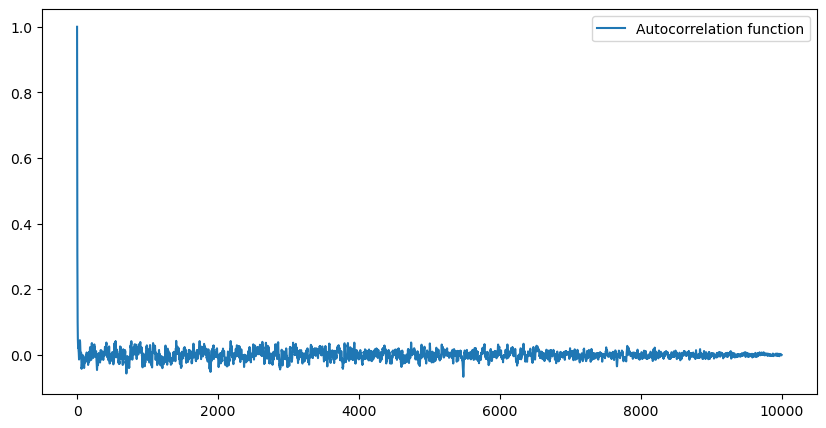

In [ ]:
#la catena deve essere ripulita perchè MonteCarlo aggiunge delle problematiche legate dal modo in cui è stato generato l campione
#I punti generati dipendono dal punto precedente: si crea una correlazione fra punti. si può trovare il tempo di autocorrelazione
#sto crosscorrelando pezzi di catena con se stessa spostata di un \delta_t. la crosscorrelazione è una convoluzione.
#Se non c'è correlazione mi aspetto che la catena sia nulla. Ci vuole un po' perchè la catena si dimentichi dei punti precedenti: tempo di rilassamento. 
#https://emcee.readthedocs.io/en/stable/tutorials/autocorr/

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

steps = [10, 20, 50, 100]
autocorrelation_time = []

for step in steps:
    # Compute the autocorrelation function
    acf = autocorr_func_1d(chain, norm=True)

    # Compute the autocorrelation time
    tau = 0.5 + np.sum(acf[1:step]) / acf[0]
    autocorrelation_time.append(tau)

# Plot the autocorrelation function
plt.figure(figsize=(10, 5))
plt.plot(acf, label="Autocorrelation function")
plt.legend()
plt.show()


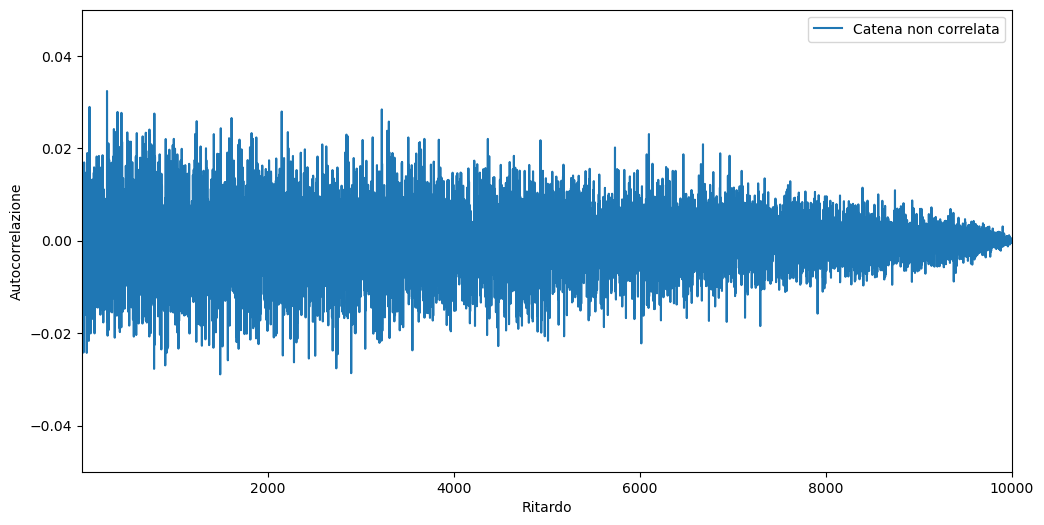

In [72]:
#la catena senza correlazione sarà attorno a zero (quello che voglio)
#stesso plot con catena non correlata

# Genera una catena non correlata con stessa media e deviazione standard
np.random.seed(42)  # Per riproducibilità
chain_random = np.random.normal(loc=np.mean(chain), scale=np.std(chain), size=len(chain))

# Calcola l’autocorrelazione
acf_random = autocorr_func_1d(chain_random)

# Plot di confronto con la catena MCMC già plottata prima
plt.figure(figsize=(12, 6))
plt.plot(acf_random, label="Catena non correlata")
plt.xlim(2, 10000)
plt.ylim(-0.05, 0.05)
plt.xlabel("Ritardo")
plt.ylabel("Autocorrelazione")
plt.legend()
plt.show()
